[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_10390/2639516442.py:117: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data = web.DataReader('F-F_Research_data_5_factors_2x3',
/tmp/ipykernel_10390/2639516442.py:117: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data = web.DataReader('F-F_Research_data_5_factors_2x3',


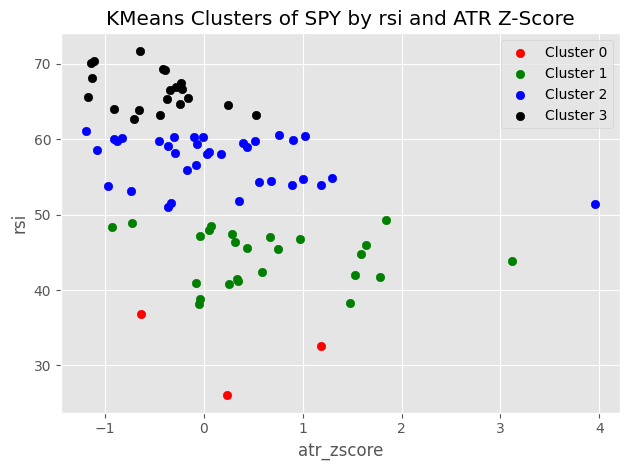

In [22]:
import pandas_datareader.data as web
import pandas as pd
import pandas_ta
import numpy as np  
import yfinance as yf
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# Code block to introduce all stocks under the S&P 500 index
# sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
# sp500['Symbol'] = sp500['Symbol'].str.replace('.','-')
# symbols_list = sp500['Symbol'].unique().tolist()
# to_remove = ['SOLV', 'VLTO', 'SW', 'GEV'] # Yfinance does not have legacy data for these tickers, consider reintegrating
# symbols_list = [symbol for symbol in symbols_list if symbol not in to_remove]

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:, 0]
    return macd.sub(macd.mean()).div(macd.std())


def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
        low=stock_data['low'],
        close=stock_data['close'],
        length=14)
    atr.dropna(inplace=True)
    z_atr = atr.sub(atr.mean()).div(atr.std())
    return z_atr


def calculate_returns(df):
    outlier_cutoff = 0.005
    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:
        df[f'return_{lag}m'] = (df['close']
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                       upper=x.quantile(1-outlier_cutoff)))
                                .add(1)
                                .pow(1/lag)
                                .sub(1))
    return df


def plot_clusters(data):
    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0['atr_zscore'], cluster_0['rsi'], color = 'red', label='Cluster 0')
    plt.scatter(cluster_1['atr_zscore'], cluster_1['rsi'], color = 'green', label='Cluster 1')
    plt.scatter(cluster_2['atr_zscore'], cluster_2['rsi'], color = 'blue', label='Cluster 2')
    plt.scatter(cluster_3['atr_zscore'], cluster_3['rsi'], color = 'black', label='Cluster 3')

    plt.xlabel('atr_zscore')
    plt.ylabel('rsi')
    plt.title('KMeans Clusters of SPY by rsi and ATR Z-Score')
    
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return


def get_clusters(data, initial_centroids):
    data['cluster'] = KMeans(n_clusters=4,
                          random_state=0,
                          init=initial_centroids).fit(data).labels_
    return data


end_date = '2025-05-01'
start_date = pd.to_datetime(end_date) - pd.DateOffset(years=8)


df = yf.download(tickers = 'SPY',
                start = start_date,
                end = end_date,
                timeout= 5.0)
                # .stack(future_stack=True)
df.columns = df.columns.get_level_values(0) 

df.columns = df.columns.str.lower()

df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['close'])-np.log(df['open']))**2)

df['rsi'] = pandas_ta.rsi(df['close'], length=20)

# Check RSI plot
# df.xs('SPY', level=1)['rsi'].plot(title='SPY RSI', figsize=(10, 5), color='blue') 

df['bb_low'] = df['close'].transform(lambda x:pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 0])
df['bb_mid'] = df['close'].transform(lambda x:pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 1])
df['bb_high'] = df['close'].transform(lambda x:pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 2])
df['atr_zscore'] = compute_atr(df)
df['macd'] = compute_macd(df['close'])
df['dollar_volume'] = (df['close'] * df['volume'])/1e6
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'open', 'high', 'low', 'volume']]

adjusted_volume = df['dollar_volume'].resample('ME').mean().to_frame('dollar_volume')
df_monthly = df[last_cols].resample('ME').last()

data = (pd.concat([adjusted_volume, df_monthly], axis=1)).dropna()
data['dollar_volume'] = data.loc[:, 'dollar_volume'].rolling(5*12, min_periods=12).mean().dropna()
data['dollar_vol_rank'] = (data['dollar_volume'].rank(ascending=False)).dropna()
data = data.drop(['dollar_volume', 'dollar_vol_rank'], axis=1)


data = calculate_returns(data).dropna()

factor_data = web.DataReader('F-F_Research_data_5_factors_2x3',
               'famafrench',
               start='2010')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('ME').last().div(100)
factor_data.index.name = 'date'
factor_data = factor_data.join(data['return_1m'])

endog = factor_data['return_1m']
exog = sm.add_constant(factor_data.drop(columns='return_1m',axis=1))
rolling_ols = RollingOLS(endog=endog, exog=exog, window=min(24,factor_data.shape[0]), min_nobs=len(factor_data.columns)+1)
rolling_betas = rolling_ols.fit(params_only=True).params.drop(columns='const', axis =1)
# rolling_betas
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
data = data.join(rolling_betas)
data.loc[:, factors] = data[factors].apply(lambda x: x.fillna(x.mean()))
data = data.drop('close', axis=1)
data = data.drop('cluster', axis=1, errors='ignore')

target_rsi_values = [30, 45, 55, 70]
feature_count = data.shape[1]
rsi_index = data.columns.get_loc("rsi")
initial_centroids = np.zeros((len(target_rsi_values),feature_count))
initial_centroids[:, rsi_index] = target_rsi_values
initial_centroids

data = get_clusters(data.dropna(), initial_centroids)

plt.style.use('ggplot')
plot_clusters(data)





# print(df)
# print(type(df.index))       # Shows the index type
# print(df.index.nlevels) 
# print(df.index.names)
# print(df.columns)